In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler

In [4]:
###mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the stock price data

In [5]:
stock_df= pd.read_csv('./drive/My Drive/Colab Notebooks/GME_stock.csv',parse_dates=["date"])

In [6]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666


In [7]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


The data has inverted order by date. We need to change it in  date ascending order.

In [8]:
stock_df=stock_df.sort_values(by="date", ascending=True)

In [9]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838


Split the dataframe into training set and test set


> there are some NaN values when we create new features and target columns. one way is to delete these column. the other way is to use SimpleImputer.
<br> lets just delete them first
<br> TODO, add SimpleImputer in preprocessing pipeline.



Build BPNN model


In [10]:
def convert2matrix(data_arr, look_back):
 X, Y =[], []
 for i in range(len(data_arr)-look_back):
  d=i+look_back  
  X.append(data_arr[i:d,0])
  Y.append(data_arr[d,0])
 return np.array(X), np.array(Y)

In [11]:
df = stock_df['close_price']  ### just take close price information for model training

In [12]:
arr_data = np.array(df).reshape(-1,1)
# test=[10.05000019, 10.        ,  9.94999981,  9.55000019,  9.875     ,
#         9.85000038,  9.67500019,  9.75      ,  9.75      ,  9.57499981]
# test=np.array(test).reshape(-1,1)  ###非常有用！

In [13]:
X,Y= convert2matrix(arr_data, 30)

In [14]:
stock_price_new_df=pd.concat([pd.DataFrame(X),pd.DataFrame(Y)],axis=1)

In [15]:
stock_price_new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0
0,10.050,10.000,9.950,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.65,9.860,9.990,10.300,10.100
1,10.000,9.950,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.86,9.990,10.300,10.100,9.525
2,9.950,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.860,9.99,10.300,10.100,9.525,9.320
3,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.860,9.990,10.30,10.100,9.525,9.320,9.300
4,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.860,9.990,10.300,10.10,9.525,9.320,9.300,9.475


In [16]:
stock_price_new_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0
4738,16.940001,13.66,14.12,13.31,12.72,13.85,13.850000,14.830000,15.630000,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002
4739,13.660000,14.12,13.31,12.72,13.85,13.85,14.830000,15.630000,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001
4740,14.120000,13.31,12.72,13.85,13.85,14.83,15.630000,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001,147.979996
4741,13.310000,12.72,13.85,13.85,14.83,15.63,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001,147.979996,347.510010
4742,12.720000,13.85,13.85,14.83,15.63,15.53,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001,147.979996,347.510010,193.600006


In [17]:
stock_price_new_df.shape

(4743, 31)

In [18]:
train_size=3794
train,test=stock_price_new_df[0:train_size],stock_price_new_df[train_size:]

In [19]:
train.shape

(3794, 31)

In [20]:
test.shape

(949, 31)

In [21]:
trainX=train.iloc[:,:-1]
trainY=train.iloc[:,-1:]
testX=test.iloc[:,:-1]
testY=test.iloc[:,-1:]

In [22]:
from keras.models import Sequential
from keras.layers import Dense
def model_dnn(look_back):
  model=Sequential()
  model.add(Dense(units=32,input_dim=look_back,activation='relu'))
  model.add(Dense(8,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])
  return model

In [23]:
model=model_dnn(30)
history=model.fit(trainX,trainY,
                  epochs=100,
                  batch_size=30,
                  verbose=1,
                  validation_data=(testX,testY),
                  shuffle=False)

Epoch 1/100
127/127 [==============================] - 1s 6ms/step - loss: 45.0975 - mse: 45.0975 - mae: 5.1923 - val_loss: 147.7742 - val_mse: 147.7742 - val_mae: 1.7903
Epoch 2/100
127/127 [==============================] - 0s 2ms/step - loss: 3.8668 - mse: 3.8668 - mae: 1.3127 - val_loss: 143.3639 - val_mse: 143.3639 - val_mae: 1.7157
Epoch 3/100
127/127 [==============================] - 0s 2ms/step - loss: 3.1968 - mse: 3.1968 - mae: 1.1694 - val_loss: 139.3857 - val_mse: 139.3857 - val_mae: 1.6349
Epoch 4/100
127/127 [==============================] - 0s 2ms/step - loss: 2.6943 - mse: 2.6943 - mae: 1.0545 - val_loss: 135.4088 - val_mse: 135.4088 - val_mae: 1.5525
Epoch 5/100
127/127 [==============================] - 0s 2ms/step - loss: 2.3092 - mse: 2.3092 - mae: 0.9659 - val_loss: 131.6207 - val_mse: 131.6207 - val_mae: 1.4736
Epoch 6/100
127/127 [==============================] - 0s 2ms/step - loss: 2.0205 - mse: 2.0205 - mae: 0.9052 - val_loss: 128.0463 - val_mse: 128.0463 - 

In [24]:
def model_loss(history):
  plt.figure(figsize=(8,4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show()

Train Root Mean Squared Error(RMSE): 0.98; Train Mean Absolute Error(MAE) : 0.74 
Test Root Mean Squared Error(RMSE): 8.81; Test Mean Absolute Error(MAE) : 1.22 


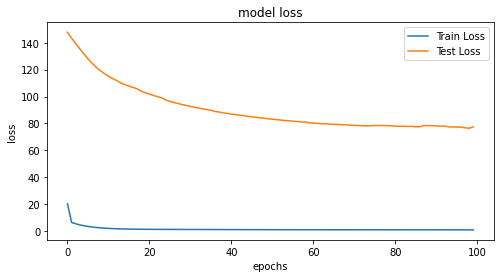

In [25]:
train_score = model.evaluate(trainX, trainY, verbose=0)  ##model.evaluate要用起来！
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))  ###这里用了np.sqrt()
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [26]:
def prediction_plot(testY,test_predict):
  len_prediction=[x for x in range(len(testY))]
  plt.figure(figsize=(8,4))
  plt.plot(len_prediction[-200:],testY[-200:],marker='.',label='actual')
  plt.plot(len_prediction[-200:], test_predict[-200:],'r',label='prediction')
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('stock_price',size=15)
  plt.xlabel('Time step',size=15)
  plt.legend(fontsize=15)
  plt.title('Prediction VS Actual Stock Price after 30 days_Test data')
  plt.show()

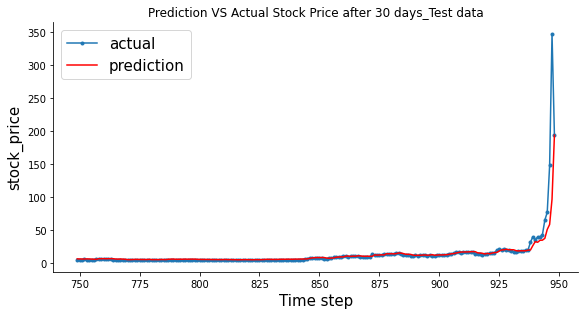

In [27]:
test_predict=model.predict(testX)
prediction_plot(testY,test_predict)

In [28]:
from sklearn.metrics import r2_score
R_2 = r2_score(testY,test_predict)
R_2

0.6479524525330589

In [29]:
testY= np.array(testY).reshape(-1,1)
y_var_test=testY[1:]-testY[:len(testY)-1]
y_var_predict=test_predict[1:]-test_predict[:len(test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)


预测涨跌正确: 0.49050632911392406


**Use RNN(Recurrent Neural Network) model**

In [35]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping


In [37]:
def convert2matrix(data_arr, look_back):
   X, Y =[], []
   for i in range(len(data_arr)-look_back):
     d=i+look_back
     X.append(data_arr[i:d,])
     Y.append(data_arr[d,])
   return np.array(X), np.array(Y)

In [51]:
trial_run_df=stock_df.head()

In [69]:
trial_run_data=trial_run_df['close_price']
trial_run_data=np.array(trial_run_data).reshape(-1,1)
trial_run_data

array([[10.05000019],
       [10.        ],
       [ 9.94999981],
       [ 9.55000019],
       [ 9.875     ]])

In [54]:
X,Y=convert2matrix(trial_run_data, 2)

In [72]:
X.shape

(3, 2, 1)

In [70]:
trainX = np.reshape(X, (X.shape[0], 1, X.shape[1]))
trainX

array([[[10.05000019, 10.        ]],

       [[10.        ,  9.94999981]],

       [[ 9.94999981,  9.55000019]]])

In [71]:
trainX.shape

(3, 1, 2)

In [73]:
def model_rnn(look_back):
  model=Sequential()
  model.add(SimpleRNN(units=32,input_shape=(1,look_back),activation='relu'))
  model.add(Dense(8,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])
  return model

In [74]:
model=model_rnn(2)

In [32]:
# trainX.shape

In [33]:
# trainY

In [75]:
history=model.fit(trainX,Y,
                  epochs=10,
                  batch_size=1,
                  verbose=1,
                  shuffle=False)

Epoch 1/10
3/3 [==============================] - 1s 5ms/step - loss: 105.4503 - mse: 105.4503 - mae: 10.2672
Epoch 2/10
3/3 [==============================] - 0s 4ms/step - loss: 104.2560 - mse: 104.2560 - mae: 10.2089
Epoch 3/10
3/3 [==============================] - 0s 4ms/step - loss: 103.1439 - mse: 103.1439 - mae: 10.1543
Epoch 4/10
3/3 [==============================] - 0s 4ms/step - loss: 102.2582 - mse: 102.2582 - mae: 10.1107
Epoch 5/10
3/3 [==============================] - 0s 4ms/step - loss: 101.6309 - mse: 101.6309 - mae: 10.0796
Epoch 6/10
3/3 [==============================] - 0s 8ms/step - loss: 101.0418 - mse: 101.0418 - mae: 10.0504
Epoch 7/10
3/3 [==============================] - 0s 3ms/step - loss: 100.4916 - mse: 100.4916 - mae: 10.0229
Epoch 8/10
3/3 [==============================] - 0s 5ms/step - loss: 99.9791 - mse: 99.9791 - mae: 9.9974
Epoch 9/10
3/3 [==============================] - 0s 4ms/step - loss: 99.5028 - mse: 99.5028 - mae: 9.9735
Epoch 10/10
3/3 